In [43]:
%matplotlib inline


# 04 eXtreme Gradient Boosting regression

In [67]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

import xgboost
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, KFold
import pandas as pd
from tqdm import tqdm

pd.set_option('display.max_columns', 30)
pd.set_option('display.precision', 3)


## Time-independent regression with `df_X_pca` and `df_y`




In [52]:
df_X_pca = pd.read_pickle('df_X_pca.pkl')
X_cols = df_X_pca.columns

df_y = pd.read_pickle('df_y.pkl')
y_cols = df_y.columns

X = df_X_pca.to_numpy()
y = df_y.to_numpy()

print('X.shape = ', X.shape, ', y.shape = ', y.shape)

X.shape =  (1229, 50) , y.shape =  (1229, 6)


### Train-val-test split

Even when attempting time-independent regression, we cannot shuffle the data set before making train and test plit. If the model should be able to predict output variables ahead in time, it has to work well on a chronologically split data set.

For XGBoost we use a sperarate (random) part of the training set as evaluation set.


In [68]:
split_test = int(len(X)*0.8)
X_train, X_test = X[:split_test,:], X[split_test+1:,:]
y_train, y_test = y[:split_test,:], y[split_test+1:,:]

X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2
print('X_train:', X_train.shape, 'X_val:', X_val.shape, 'X_test:', X_test.shape)
print('y_train:', y_train.shape, 'y_val:', y_val.shape, 'y_test:', y_test.shape)

Note = 'PCA50. Random train/val but end as test.'

X_train: (737, 50) X_val: (246, 50) X_test: (245, 50)
y_train: (737, 6) y_val: (246, 6) y_test: (245, 6)


In [69]:
params = {
    "objective": "reg:squarederror",
    "subsample": 0.7, # subsample ratio of columns when constructing each tree.
    'colsample_bytree': 0.8,
    'min_child_weight': 5,
    #"alpha": 0.5, # L1 regularization term on weights. Increasing this value will make model more conservative.
    #"lambda": 1, # L2 regularization term on weights. Increasing this value will make model more conservative.
    "gamma": 0.01, # Minimum loss reduction required to make a further partition on a leaf node of the tree. Higher -> more conservative. [0,inf]
    "learning_rate": 0.03, # default 0.3 
    "max_depth": 5, # default 3
    "n_estimators": 400, # default 100
    "early_stopping_rounds": 20,
    "tree_method": 'hist'
}

### Fit regression model


In [72]:
# Prepare dataframe of rmse results and parameter values, or load existing dataframe from file if `fit_file`exists

fit_file = '04_fitting_results.pkl' # NB: Update name according to notebook number

if os.path.exists(fit_file):
    fit_results = pd.read_pickle(fit_file)
else:
    res_cols = ['Note']
    for col in df_y.columns:
        res_cols.append(col+' S_e')
    res_cols.append('S_e mean')
    for key in params.keys():
        res_cols.append(key)
    res_cols.append('Training time')
        
    fit_results = pd.DataFrame(columns=res_cols)

for i in tqdm(range(20)):
    start_time = datetime.now()


    # ----------------- Calculate root mean squared error of predictions and -------------------------
    # ----------------- store results in dataframe together with parameter values used -------------------------
    res_labels = ['Note']
    res_values = [Note]

    regs = []
    y_test_estimated = []
    y_test_error = []
    S_e_values = []

    for i in range(y_train.shape[1]):
        seed = int(np.random.random()*100)
        reg = XGBRegressor(**params, random_state=seed) 
        #reg.set_params(n_threads=2)
        history = reg.fit(X_train, y_train[:,i], eval_set=[(X_val, y_val[:,i])], verbose=0) # Fit model for label i
        regs.append(reg)

        y_test_estimated.append(reg.predict(X_test)) # Predict label values on test set
        y_test_error.append(y_test[:,i] - y_test_estimated[i])
        S_e = np.std(y_test_error[i])/np.std(y_test[:,i])
        res_values.append(S_e)
        label = y_cols[i]
        res_labels.append(label+' S_e')

        S_e_values.append(S_e)

    res_labels.append('S_e mean')
    res_values.append(np.mean(S_e_values))

    for key in params.keys():
        res_values.append(params[key])
        res_labels.append(key)

    training_time = (datetime.now() - start_time).total_seconds()
    res_values.append(training_time)
    res_labels.append('Training time')

    df_tmp = pd.DataFrame([res_values], columns=res_labels, index=[datetime.now().date()])
    fit_results = pd.concat([fit_results,df_tmp])
    #fit_results = fit_results.sort_values('R2', ascending=False)
    
fit_results.to_pickle(fit_file)
fit_results

100%|██████████| 20/20 [02:56<00:00,  8.83s/it]


,Note,y1 S_e,y2 S_e,y3 S_e,y4 S_e,y5 S_e,y6 S_e,S_e mean,objective,subsample,colsample_bytree,min_child_weight,gamma,learning_rate,max_depth,n_estimators,early_stopping_rounds,tree_method,Training time
2023-04-27,PCA50. Random train/val but end as test.,1.137,0.709,1.060,0.757,0.838,0.996,0.916,reg:squarederror,0.7,0.8,5,0.01,0.03,5,400,20,hist,8.895
2023-04-27,PCA50. Random train/val but end as test.,1.144,0.682,1.077,0.776,0.835,1.024,0.923,reg:squarederror,0.7,0.8,5,0.01,0.03,5,400,20,hist,9.666
2023-04-27,PCA50. Random train/val but end as test.,1.073,0.680,1.047,0.767,0.841,1.021,0.905,reg:squarederror,0.7,0.8,5,0.01,0.03,5,400,20,hist,8.966
2023-04-27,PCA50. Random train/val but end as test.,1.091,0.697,1.034,0.769,0.820,1.005,0.903,reg:squarederror,0.7,0.8,5,0.01,0.03,5,400,20,hist,8.037
2023-04-27,PCA50. Random train/val but end as test.,1.158,0.677,1.056,0.763,0.824,0.973,0.909,reg:squarederror,0.7,0.8,5,0.01,0.03,5,400,20,hist,7.736
2023-04-27,PCA50. Random train/val but end as test.,1.164,0.694,1.029,0.758,0.821,0.979,0.907,reg:squarederror,0.7,0.8,5,0.01,0.03,5,400,20,hist,8.541
2023-04-27,PCA50. Random train/val but end as test.,1.061,0.700,1.056,0.768,0.841,0.996,0.904,reg:squarederror,0.7,0.8,5,0.01,0.03,5,400,20,hist,10.519
2023-04-27,PCA50. Random train/val but end as test.,1.153,0.693,1.020,0.753,0.843,0.986,0.908,reg:squarederror,0.7,0.8,5,0.01,0.03,5,400,20,hist,10.632
2023-04-27,PCA50. Random train/val but end as test.,1.095,0.689,1.043,0.757,0.811,0.952,0.891,reg:squarederror,0.7,0.8,5,0.01,0.03,5,400,20,hist,7.873
2023-04-27,PCA50. Random train/val but end as test.,1.146,0.692,1.042,0.779,0.831,1.021,0.918,reg:squarederror,0.7,0.8,5,0.01,0.03,5,400,20,hist,12.430


In [73]:
stats = fit_results.loc[fit_results['Note']=='PCA50. Random train/val but end as test.']
stats.loc['mean'] = stats.mean()
stats.loc['std'] = stats.std()
stats

C:\Users\christiano\AppData\Local\Temp\ipykernel_22476\393142404.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  stats.loc['mean'] = stats.mean()
C:\Users\christiano\AppData\Local\Temp\ipykernel_22476\393142404.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  stats.loc['std'] = stats.std()


,Note,y1 S_e,y2 S_e,y3 S_e,y4 S_e,y5 S_e,y6 S_e,S_e mean,objective,subsample,colsample_bytree,min_child_weight,gamma,learning_rate,max_depth,n_estimators,early_stopping_rounds,tree_method,Training time
2023-04-27,PCA50. Random train/val but end as test.,1.137,0.709,1.060,0.757,0.838,0.996,0.916,reg:squarederror,7.000e-01,8.000e-01,5,1.000e-02,3.000e-02,5,400,20,hist,8.895
2023-04-27,PCA50. Random train/val but end as test.,1.144,0.682,1.077,0.776,0.835,1.024,0.923,reg:squarederror,7.000e-01,8.000e-01,5,1.000e-02,3.000e-02,5,400,20,hist,9.666
2023-04-27,PCA50. Random train/val but end as test.,1.073,0.680,1.047,0.767,0.841,1.021,0.905,reg:squarederror,7.000e-01,8.000e-01,5,1.000e-02,3.000e-02,5,400,20,hist,8.966
2023-04-27,PCA50. Random train/val but end as test.,1.091,0.697,1.034,0.769,0.820,1.005,0.903,reg:squarederror,7.000e-01,8.000e-01,5,1.000e-02,3.000e-02,5,400,20,hist,8.037
2023-04-27,PCA50. Random train/val but end as test.,1.158,0.677,1.056,0.763,0.824,0.973,0.909,reg:squarederror,7.000e-01,8.000e-01,5,1.000e-02,3.000e-02,5,400,20,hist,7.736
2023-04-27,PCA50. Random train/val but end as test.,1.164,0.694,1.029,0.758,0.821,0.979,0.907,reg:squarederror,7.000e-01,8.000e-01,5,1.000e-02,3.000e-02,5,400,20,hist,8.541
2023-04-27,PCA50. Random train/val but end as test.,1.061,0.700,1.056,0.768,0.841,0.996,0.904,reg:squarederror,7.000e-01,8.000e-01,5,1.000e-02,3.000e-02,5,400,20,hist,10.519
2023-04-27,PCA50. Random train/val but end as test.,1.153,0.693,1.020,0.753,0.843,0.986,0.908,reg:squarederror,7.000e-01,8.000e-01,5,1.000e-02,3.000e-02,5,400,20,hist,10.632
2023-04-27,PCA50. Random train/val but end as test.,1.095,0.689,1.043,0.757,0.811,0.952,0.891,reg:squarederror,7.000e-01,8.000e-01,5,1.000e-02,3.000e-02,5,400,20,hist,7.873
2023-04-27,PCA50. Random train/val but end as test.,1.146,0.692,1.042,0.779,0.831,1.021,0.918,reg:squarederror,7.000e-01,8.000e-01,5,1.000e-02,3.000e-02,5,400,20,hist,12.430


## Time dependent regression with `df_X_lagged` and `df_y_lagged`

The reason for not using `df_y` here is that `df_X_lagged` contains fewer rows and we need a coherent set of labels



In [74]:
df_X_lagged = pd.read_pickle('df_X_lagged.pkl')
X_cols = df_X_lagged.columns

df_y_lagged = pd.read_pickle('df_y_lagged.pkl')
y_cols = df_y_lagged.columns

X = df_X_lagged.to_numpy()
y = df_y_lagged.to_numpy()

print('X.shape = ', X.shape, ', y.shape = ', y.shape)

X.shape =  (1224, 330) , y.shape =  (1224, 6)


### Train-val-test split


In [75]:
split_test = int(len(X)*0.8)
X_train, X_test = X[:split_test,:], X[split_test+1:,:]
y_train, y_test = y[:split_test,:], y[split_test+1:,:]

X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2
print('X_train:', X_train.shape, 'X_val:', X_val.shape, 'X_test:', X_test.shape)
print('y_train:', y_train.shape, 'y_val:', y_val.shape, 'y_test:', y_test.shape)

Note = 'df_X_lagged. Random train/val but end as test.'

X_train: (734, 330) X_val: (245, 330) X_test: (244, 330)
y_train: (734, 6) y_val: (245, 6) y_test: (244, 6)


### Fit regression model
Using the same hyperparameters


In [77]:
# Prepare dataframe of rmse results and parameter values, or load existing dataframe from file if `fit_file`exists

fit_file = '04_fitting_results.pkl' # NB: Update name according to notebook number

if os.path.exists(fit_file):
    fit_results = pd.read_pickle(fit_file)
else:
    res_cols = ['Note']
    for col in df_y.columns:
        res_cols.append(col+' S_e')
    res_cols.append('S_e mean')
    for key in params.keys():
        res_cols.append(key)
    res_cols.append('Training time')
        
    fit_results = pd.DataFrame(columns=res_cols)

for i in tqdm(range(20)):
    start_time = datetime.now()

    # ----------------- Calculate root mean squared error of predictions and -------------------------
    # ----------------- store results in dataframe together with parameter values used -------------------------
    res_labels = ['Note']
    res_values = [Note]

    regs = []
    y_test_estimated = []
    y_test_error = []
    S_e_values = []

    for i in range(y_train.shape[1]):
        seed = int(np.random.random()*100)
        reg = XGBRegressor(**params, random_state=seed) 
        #reg.set_params(n_threads=2)
        history = reg.fit(X_train, y_train[:,i], eval_set=[(X_val, y_val[:,i])], verbose=0) # Fit model for label i
        regs.append(reg)

        y_test_estimated.append(reg.predict(X_test)) # Predict label values on test set
        y_test_error.append(y_test[:,i] - y_test_estimated[i])
        S_e = np.std(y_test_error[i])/np.std(y_test[:,i])
        res_values.append(S_e)
        label = y_cols[i]
        res_labels.append(label+' S_e')

        S_e_values.append(S_e)

    res_labels.append('S_e mean')
    res_values.append(np.mean(S_e_values))

    for key in params.keys():
        res_values.append(params[key])
        res_labels.append(key)

    training_time = (datetime.now() - start_time).total_seconds()
    res_values.append(training_time)
    res_labels.append('Training time')

    df_tmp = pd.DataFrame([res_values], columns=res_labels, index=[datetime.now().date()])
    fit_results = pd.concat([fit_results,df_tmp])
    #fit_results = fit_results.sort_values('R2', ascending=False)

fit_results.to_pickle(fit_file)
fit_results

100%|██████████| 20/20 [14:06<00:00, 42.31s/it]


,Note,y1 S_e,y2 S_e,y3 S_e,y4 S_e,y5 S_e,y6 S_e,S_e mean,objective,subsample,colsample_bytree,min_child_weight,gamma,learning_rate,max_depth,n_estimators,early_stopping_rounds,tree_method,Training time
2023-04-27,PCA50. Random train/val but end as test.,1.137,0.709,1.060,0.757,0.838,0.996,0.916,reg:squarederror,0.7,0.8,5,0.01,0.03,5,400,20,hist,8.895
2023-04-27,PCA50. Random train/val but end as test.,1.144,0.682,1.077,0.776,0.835,1.024,0.923,reg:squarederror,0.7,0.8,5,0.01,0.03,5,400,20,hist,9.666
2023-04-27,PCA50. Random train/val but end as test.,1.073,0.680,1.047,0.767,0.841,1.021,0.905,reg:squarederror,0.7,0.8,5,0.01,0.03,5,400,20,hist,8.966
2023-04-27,PCA50. Random train/val but end as test.,1.091,0.697,1.034,0.769,0.820,1.005,0.903,reg:squarederror,0.7,0.8,5,0.01,0.03,5,400,20,hist,8.037
2023-04-27,PCA50. Random train/val but end as test.,1.158,0.677,1.056,0.763,0.824,0.973,0.909,reg:squarederror,0.7,0.8,5,0.01,0.03,5,400,20,hist,7.736
2023-04-27,PCA50. Random train/val but end as test.,1.164,0.694,1.029,0.758,0.821,0.979,0.907,reg:squarederror,0.7,0.8,5,0.01,0.03,5,400,20,hist,8.541
2023-04-27,PCA50. Random train/val but end as test.,1.061,0.700,1.056,0.768,0.841,0.996,0.904,reg:squarederror,0.7,0.8,5,0.01,0.03,5,400,20,hist,10.519
2023-04-27,PCA50. Random train/val but end as test.,1.153,0.693,1.020,0.753,0.843,0.986,0.908,reg:squarederror,0.7,0.8,5,0.01,0.03,5,400,20,hist,10.632
2023-04-27,PCA50. Random train/val but end as test.,1.095,0.689,1.043,0.757,0.811,0.952,0.891,reg:squarederror,0.7,0.8,5,0.01,0.03,5,400,20,hist,7.873
2023-04-27,PCA50. Random train/val but end as test.,1.146,0.692,1.042,0.779,0.831,1.021,0.918,reg:squarederror,0.7,0.8,5,0.01,0.03,5,400,20,hist,12.430


In [78]:
stats2 = fit_results.loc[fit_results['Note']=='df_X_lagged. Random train/val but end as test.']
stats2.loc['mean'] = stats2.mean()
stats2.loc['std'] = stats2.std()
stats2

C:\Users\christiano\AppData\Local\Temp\ipykernel_22476\2305634582.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  stats2.loc['mean'] = stats2.mean()
C:\Users\christiano\AppData\Local\Temp\ipykernel_22476\2305634582.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stats2.loc['mean'] = stats2.mean()
C:\Users\christiano\AppData\Local\Temp\ipykernel_22476\2305634582.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  stats2.loc['std'] = stats2.std()
C:\Users\christi

,Note,y1 S_e,y2 S_e,y3 S_e,y4 S_e,y5 S_e,y6 S_e,S_e mean,objective,subsample,colsample_bytree,min_child_weight,gamma,learning_rate,max_depth,n_estimators,early_stopping_rounds,tree_method,Training time
2023-04-27,df_X_lagged. Random train/val but end as test.,0.940,0.723,0.922,0.744,0.723,0.836,0.815,reg:squarederror,7.000e-01,8.000e-01,5,1.000e-02,3.000e-02,5,400,20,hist,39.539
2023-04-27,df_X_lagged. Random train/val but end as test.,0.976,0.723,0.885,0.750,0.707,0.825,0.811,reg:squarederror,7.000e-01,8.000e-01,5,1.000e-02,3.000e-02,5,400,20,hist,42.964
2023-04-27,df_X_lagged. Random train/val but end as test.,0.966,0.715,0.908,0.768,0.712,0.830,0.816,reg:squarederror,7.000e-01,8.000e-01,5,1.000e-02,3.000e-02,5,400,20,hist,54.784
2023-04-27,df_X_lagged. Random train/val but end as test.,0.948,0.709,0.905,0.749,0.724,0.832,0.811,reg:squarederror,7.000e-01,8.000e-01,5,1.000e-02,3.000e-02,5,400,20,hist,45.472
2023-04-27,df_X_lagged. Random train/val but end as test.,0.977,0.731,0.895,0.751,0.700,0.827,0.813,reg:squarederror,7.000e-01,8.000e-01,5,1.000e-02,3.000e-02,5,400,20,hist,40.315
2023-04-27,df_X_lagged. Random train/val but end as test.,0.974,0.721,0.896,0.771,0.738,0.815,0.819,reg:squarederror,7.000e-01,8.000e-01,5,1.000e-02,3.000e-02,5,400,20,hist,37.263
2023-04-27,df_X_lagged. Random train/val but end as test.,0.983,0.729,0.889,0.740,0.700,0.836,0.813,reg:squarederror,7.000e-01,8.000e-01,5,1.000e-02,3.000e-02,5,400,20,hist,36.564
2023-04-27,df_X_lagged. Random train/val but end as test.,0.989,0.722,0.912,0.756,0.717,0.873,0.828,reg:squarederror,7.000e-01,8.000e-01,5,1.000e-02,3.000e-02,5,400,20,hist,40.293
2023-04-27,df_X_lagged. Random train/val but end as test.,0.953,0.724,0.906,0.767,0.717,0.853,0.820,reg:squarederror,7.000e-01,8.000e-01,5,1.000e-02,3.000e-02,5,400,20,hist,40.565
2023-04-27,df_X_lagged. Random train/val but end as test.,0.994,0.710,0.921,0.742,0.710,0.827,0.817,reg:squarederror,7.000e-01,8.000e-01,5,1.000e-02,3.000e-02,5,400,20,hist,35.096


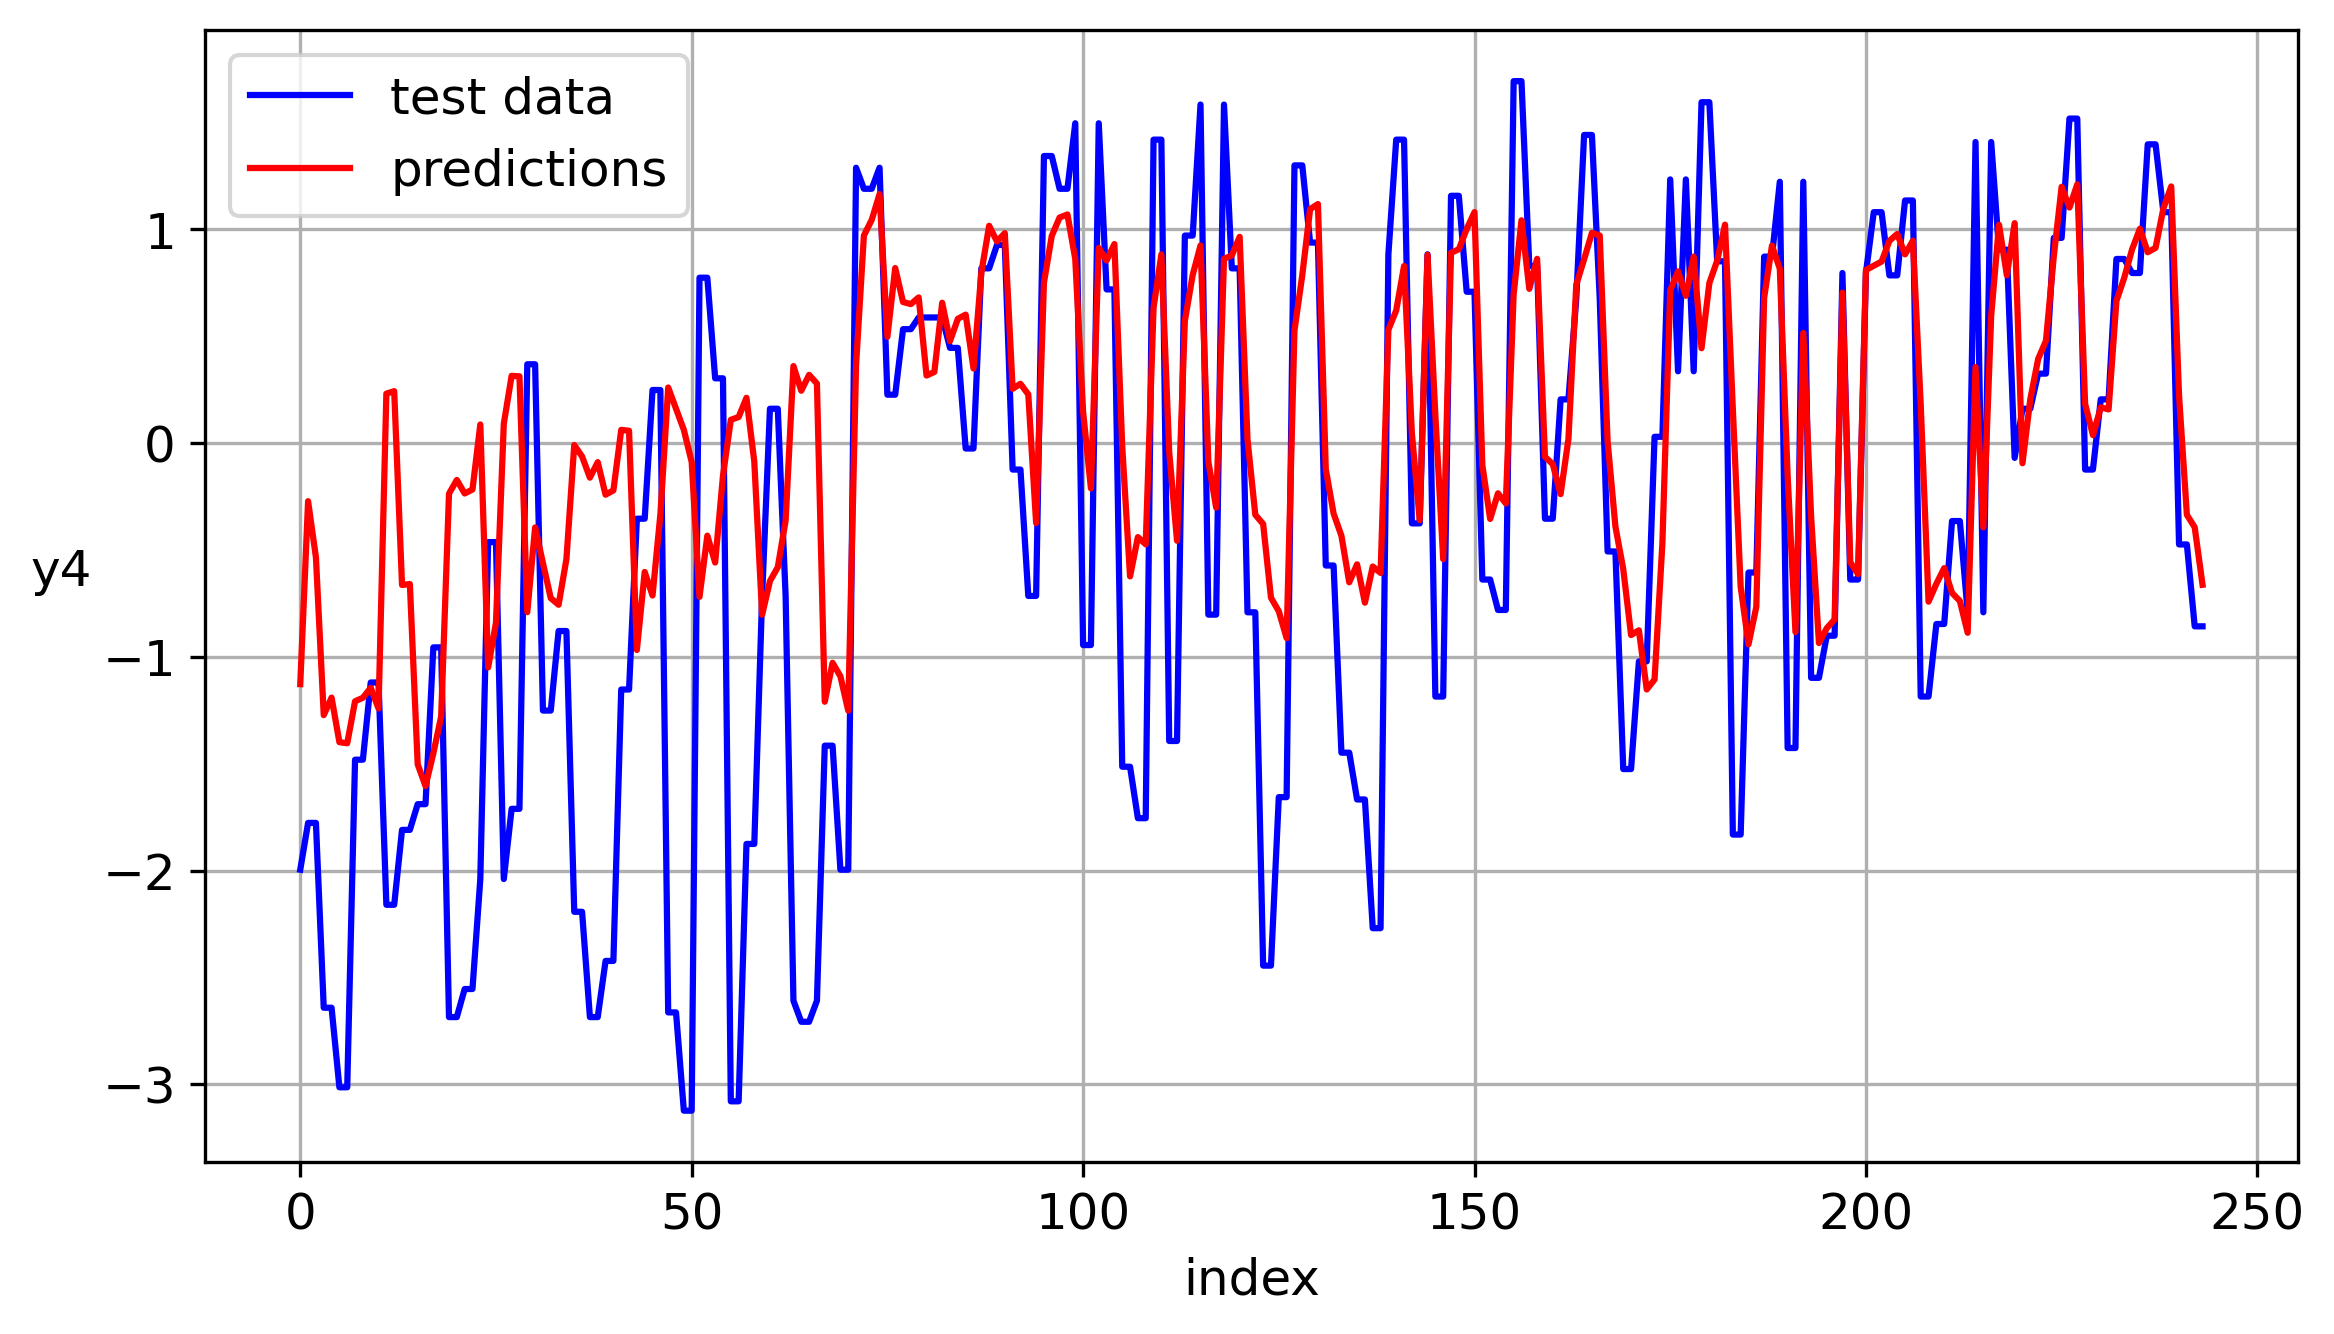

In [101]:
plt.rcParams["font.size"] = 12
plt.figure(dpi=300)

label_no = 3
split_test = int(len(X)*0.8)
idx = np.arange(len(y_test[:,label_no]))

plt.plot(idx, y_test[:,label_no], color='b', label='test data')
plt.plot(idx, y_test_estimated[label_no], color='r', label='predictions')
plt.gcf().set_size_inches(9,5)
plt.grid()
plt.legend()

plt.ylabel('y'+str(label_no+1), rotation=0, labelpad=10)
plt.xlabel('index')
plt.savefig('test_estimate_XGB.png')


In [99]:
fit_results.to_latex(columns=['y1 S_e', 'y2 S_e', 'y3 S_e', 'y4 S_e', 'y5 S_e', 'y6 S_e', 'S_e mean'], buf='fit_res_XGB.tex')

C:\Users\christiano\AppData\Local\Temp\ipykernel_20812\541578083.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  fit_results.to_latex(columns=['y1 S_e', 'y2 S_e', 'y3 S_e', 'y4 S_e', 'y5 S_e', 'y6 S_e', 'S_e mean'], buf='fit_res_XGB.tex')


Hyperparameter optimalisation with grid search

In [83]:
df_X_lagged = pd.read_pickle('df_X_lagged.pkl')
X_cols = df_X_pca.columns

df_y_lagged = pd.read_pickle('df_y_lagged.pkl')
y_cols = df_y.columns

X = df_X_lagged.to_numpy()
y = df_y_lagged.to_numpy()

split_test = int(len(X)*0.8)
X_train, X_test = X[:split_test,:], X[split_test+1:,:]
y_train, y_test = y[:split_test,3], y[split_test+1:,3]

X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2
print('X_train:', X_train.shape, 'X_val:', X_val.shape, 'X_test:', X_test.shape)
print('y_train:', y_train.shape, 'y_val:', y_val.shape, 'y_test:', y_test.shape)

X_train: (734, 330) X_val: (245, 330) X_test: (244, 330)
y_train: (734,) y_val: (245,) y_test: (244,)


Grid Search hyperparameter tuning

In [10]:
from sklearn.model_selection import GridSearchCV

def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

params = {
        'min_child_weight': [2, 5, 10],
        'gamma': [0.01, 0.02, 0.05, 0.1],
        'subsample': [0.5, 0.6, 0.7],
        'colsample_bytree': [0.6, 0.7, 0.8],
        'max_depth': [3, 4, 5],
        'objective': ["reg:squarederror", 'reg:pseudohubererror'],
        "tree_method": ['hist']
        }

xgb = XGBRegressor(learning_rate=0.03, n_estimators=400, min_child_weight=1,
                 random_state=42, silent=True,
                  nthread=1, early_stopping_rounds=20, eval_metric='rmse')
folds = 3
param_comb = 7
kf = KFold(n_splits=folds, shuffle=True, random_state=42)
grid = GridSearchCV(estimator=xgb, param_grid=params, scoring='neg_root_mean_squared_error', n_jobs=40, cv=kf.split(X_train,y_train), verbose=10)

start_time = timer(None)
grid.fit(X_train, y_train, eval_set=[(X_val, y_val)])
timer(start_time)

results = pd.DataFrame(grid.cv_results_)
results.to_csv('xgb-grid-search-results-01.csv', index=False)

SyntaxError: invalid syntax (3252123349.py, line 20)

In [100]:
params = {
        'min_child_weight': ["5, 2, 10", 5],
        'gamma': ["0.01, 0.02, 0.05, 0.1", 0.01],
        'subsample': ["0.5, 0.6, 0.7", 0.7],
        'colsample_bytree': ["0.6, 0.7, 0.8", 0.8],
        'max_depth': ["3, 4, 5", 5],
        'objective': ["reg:squarederror, reg:pseudohubererror", "reg:squarederror"],        }

GS_res = pd.DataFrame(params, index = ["", "result"]).T
GS_res.to_latex(buf='GS_res_XGB.tex')
GS_res

C:\Users\christiano\AppData\Local\Temp\ipykernel_20812\259699089.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  GS_res.to_latex(buf='GS_res_XGB.tex')


,,result
min_child_weight,"5, 2, 10",5
gamma,"0.01, 0.02, 0.05, 0.1",0.01
subsample,"0.5, 0.6, 0.7",0.7
colsample_bytree,"0.6, 0.7, 0.8",0.8
max_depth,"3, 4, 5",5
objective,"reg:squarederror, reg:pseudohubererror",reg:squarederror
